In [1]:
# Libraries
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Lux
using ComponentArrays
using LineSearches
using OrdinaryDiffEq
using OptimizationOptimisers
using Optimization
using OptimizationOptimJL
using Printf
using Random 
using SciMLSensitivity
using Plots
using DataFrames
using StableRNGs
using CSV

rng = StableRNG(1111)

  Activating project at `~/Desktop/General Case/SXS_0217`


StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

In [2]:
# Include utilities
include("utils.jl")

file2trajectory (generic function with 2 methods)

In [3]:
## Define the experiment parameters
u0 = Float32[pi, 0.0, 12.37, 1.0f-4] # χ₀, ϕ₀, p₀, e₀
tspan = (5.20913f3, 6.78f3)
datasize = 1000
tsteps = range(tspan[1], tspan[2], length = datasize)
dt_data = tsteps[2] - tsteps[1]
dt = 10.0
num_optimization_increments = 100
mass_ratio = 1
model_params = [mass_ratio] # Just the mass ratio, at least for now
mass1 = mass_ratio/(1.0+mass_ratio)
mass2 = 1.0/(1.0+mass_ratio)

0.5

# Data waveform

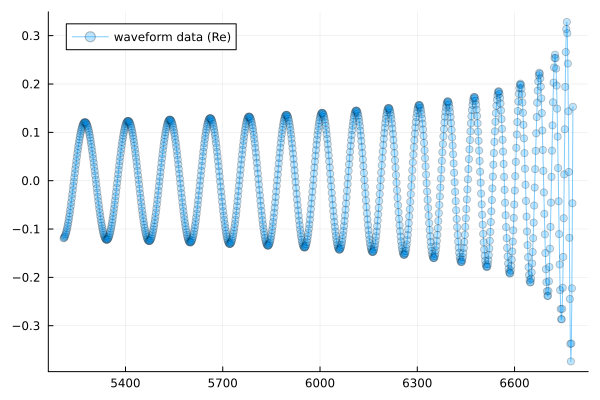

In [4]:
# Gather waveform data
x, y = file2trajectory(tsteps,"./trajectoryA.txt")
waveform_real = file2waveform(tsteps,"./waveform_real.txt")
x2, y2 = file2trajectory(tsteps,"./trajectoryB.txt")

# ploting the waveform
plt = plot(tsteps, waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data (Re)")

# Neural Network

In [5]:
# Define NN chi-phi
NN_chiphi = Chain((x) -> [cos(x[1]),1/abs(x[3]),1/sqrt(abs(x[3])),sqrt(abs(x[3])),x[3],sqrt(abs(x[3]))^3,x[3]^2,x[4],x[4]^2],
                Dense(9, 32, tanh),
                Dense(32, 2))                
NN_chiphi_params, st_chiphi  = Lux.setup(Xoshiro(), NN_chiphi)

params_chiphi = ComponentArray{Float64}(NN_chiphi_params)
nn_model_chiphi = StatefulLuxLayer(NN_chiphi, st_chiphi)

StatefulLuxLayer{true}(
    Chain(
        layer_1 = WrappedFunction(#9),
        layer_2 = Dense(9 => 32, tanh_fast),  # 320 parameters
        layer_3 = Dense(32 => 2),       # 66 parameters
    ),
)

In [6]:
# Define NN p-e
NN_pe = Chain((x) -> [1/sqrt(abs(x[3]))^3,1/abs(x[3]),1/sqrt(abs(x[3])),sqrt(abs(x[3])),x[3],sqrt(abs(x[3]))^3,x[3]^2,x[4],x[4]^2,x[3]*x[4]],
                Dense(10, 32, tanh),
                Dense(32, 2))
NN_pe_params, st_pe = Lux.setup(Xoshiro(), NN_pe)

params_pe = ComponentArray{Float64}(NN_pe_params)
nn_model_pe = StatefulLuxLayer(NN_pe, st_pe)

StatefulLuxLayer{true}(
    Chain(
        layer_1 = WrappedFunction(#11),
        layer_2 = Dense(10 => 32, tanh_fast),  # 352 parameters
        layer_3 = Dense(32 => 2),       # 66 parameters
    ),
)

In [7]:
# Parameters of the Neural Network
NN_params = ComponentVector(chiphi = params_chiphi, pe = params_pe)
NN_params_final = ComponentArray{Float64}(NN_params)

# Setting up the initial parameters
NN_params_final = NN_params_final .* 0 + Float64(1e-4) * randn(StableRNG(2031), eltype(NN_params_final), size(NN_params_final))

ComponentVector{Float64}(chiphi = (layer_1 = Float64[], layer_2 = (weight = [7.466310129349345e-5 0.00024980179107979153 … -5.976805632085828e-5 9.008321771487636e-5; 9.235554881264573e-5 0.00011319248730050147 … 2.3335719705719005e-5 -1.3383310076937746e-5; … ; -2.8673617958072803e-5 -8.942106547870995e-5 … -4.887073658279521e-5 -2.3904048837082815e-5; 0.00010928532443311825 -4.743537125181509e-5 … -3.463135486793487e-5 -0.00018588352739882057], bias = [-3.401577282812475e-5; 8.44671048246768e-5; … ; 0.00020842845538958913; -9.243014870679066e-5;;]), layer_3 = (weight = [-8.179466243060645e-5 0.00016824554743707446 … 3.6274192144346554e-5 0.00015543043179344938; 4.035425585099703e-5 8.793678181124118e-6 … -1.7914900068148026e-5 4.706110360758666e-5], bias = [0.00012997887024729718; -3.857442553835583e-5;;])), pe = (layer_1 = Float64[], layer_2 = (weight = [0.00012599020183078812 -5.657803667320495e-6 … -2.391036883996102e-5 0.00010727134932054358; -9.29760124517807e-5 -8.3705462848144

In [8]:
# Defining the PINNs
function AbstractNROrbitModel(u, model_params, t; NN_chiphi=nothing, chiphi=nothing, NN_pe=nothing, pe=nothing)
    χ, ϕ, p, e = u
    q = model_params[1]
    M=1.0

    if p <= 0
        println("p = ", p)
    end

    if isnothing(NN_chiphi)
        nn_chiphi = [1,1]
    else
        nn_chiphi = 1 .+ NN_chiphi(u, chiphi)
    end

    if isnothing(NN_pe)
        nn_pe = [0,0]
    else
        nn_pe = NN_pe(u, pe)
    end

    numer = (1+e*cos(χ))^2
    denom = M*(abs(p)^(3/2))

    χ̇ = (numer / denom) * nn_chiphi[1]
    ϕ̇ = (numer / denom) * nn_chiphi[2]
    ṗ = nn_pe[1]
    ė = nn_pe[2]

    return [χ̇, ϕ̇, ṗ, ė]
end

AbstractNROrbitModel (generic function with 1 method)

In [9]:
# Combining the both PINNs
function ODE_model(u, NN_params_final, t)
    NN_params1 = NN_params_final.chiphi
    NN_params2 = NN_params_final.pe
    du = AbstractNROrbitModel(u, model_params, t, NN_chiphi = nn_model_chiphi, chiphi = NN_params1, NN_pe = nn_model_pe, pe = NN_params2)
    return du
end

ODE_model (generic function with 1 method)

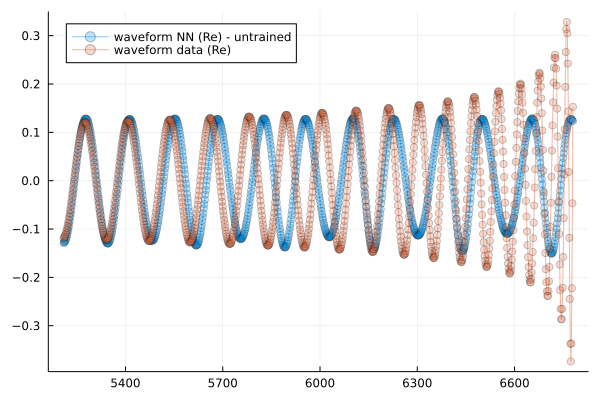

In [10]:
# Solving the edo without training
prob_nn = ODEProblem(ODE_model, u0, tspan, NN_params_final)
soln_nn = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params_final, saveat = tsteps, dt = dt, adaptive=false))
waveform_nn_real, waveform_nn_imag = compute_waveform(dt_data, soln_nn, mass_ratio)

# Plotting the solution without training
plot(tsteps, waveform_nn_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform NN (Re) - untrained")
Plots.plot!(tsteps, waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data (Re)")

In [11]:
## Define the loss function
function loss(NN_params_final; saveat=tsteps)
    tspan = (saveat[1],saveat[end])
    pred_soln = solve(remake(prob_nn, p = NN_params_final, tspan=tspan), RK4(),
                            saveat = saveat, dt = dt, adaptive=false, sensealg=BacksolveAdjoint(checkpointing=true))
    pred_waveform_real, pred_waveform_imag = compute_waveform(dt_data, pred_soln, mass_ratio)
    p = pred_soln[3,:]
    e = pred_soln[4,:]

    N = length(pred_waveform_real)
    loss = 1/N * (
            sum(abs2, waveform_real[1:N] .- pred_waveform_real)
        + 1.0f3*sum(abs2, max.(d_dt(p,dt_data),0.0))
        + 1.0f2*sum(abs2, max.(d2_dt2(p,dt_data),0.0))
        + 1.0f1*sum(abs2, max.(-e,0.0))
        + 1.0f0*sum(abs2, max.(e[p .>= 6 + 2*e[1]] .- e[1],0.0)))
        + 1.0f-1*sum(abs2, NN_params_final)

    return loss, pred_waveform_real, pred_waveform_imag, pred_soln
end

loss (generic function with 1 method)

In [12]:
# Test loss function
loss(NN_params_final)

const losses = []

callback(θ,l,pred_waveform_real, pred_waveform_imag, pred_soln; doplot = true) = begin
    push!(losses, l)
    display(l)
    #plt1 = plot(tsteps, waveform_real,markershape=:circle, markeralpha = 0.25,linewidth = 2, alpha = 0.5,label="wform data (Re)", legend=:topleft)
    #N = length(pred_waveform_real)
    #plot!(plt1, tsteps[1:N], pred_waveform_real,markershape=:circle, markeralpha = 0.25,linewidth = 2, alpha = 0.5,label="wform NN (Re)")

    #pred_orbit = soln2orbit(pred_soln)
    #orbit_nn1, orbit_nn2 = one2two(pred_orbit, mass1, mass2)
    #N = size(orbit_nn1,2)
    #plt2 = plot(x[1:N],y[1:N],linewidth = 2, alpha = 0.5,label="orbit data")
    #plot!(plt2, orbit_nn1[1,1:end], orbit_nn1[2,1:end],linewidth = 2, alpha = 0.5,label="orbit NN")
    #χ = pred_soln[1,:]
    #ϕ = pred_soln[2,:]
    #p = pred_soln[3,:]
    #e = pred_soln[4,:]
    #plt3 = plot(tsteps[1:N], p, linewidth = 2, alpha = 0.5, label="p", legend=:best)
    #plt4 = plot(tsteps[1:N], e, linewidth = 2, alpha = 0.5, label="e", legend=:topleft)
    #plt = plot(plt1, plt2, plt3, plt4, layout= @layout [a; [b{0.6w} [c;d]]])

    #if doplot
    #    display(plot(plt))
    #end
    # Tell sciml_train to not halt the optimization. If return true, then
    # optimization stops.
    return false
end

callback (generic function with 1 method)

In [13]:
optimization_increments = [collect(40:10:num_optimization_increments-5)..., num_optimization_increments-1, num_optimization_increments]

for i in optimization_increments
    println("optimization increment :: ", i, " of ", num_optimization_increments)
    tsteps_increment = tsteps[tsteps .<= tspan[1] + i*(tspan[2] - tspan[1])/num_optimization_increments]
    
    tmp_loss(p, _) = loss(p, saveat=tsteps_increment)
    
    NN_params_final = NN_params_final .+ Float64(1e-6) * randn(eltype(NN_params_final), size(NN_params_final))
    
    optf = Optimization.OptimizationFunction(tmp_loss, Optimization.AutoZygote())
    optprob = Optimization.OptimizationProblem(optf, NN_params_final, nothing)  # `nothing` as the dummy parameter
    
    if i < optimization_increments[end-1]
        res = Optimization.solve(optprob, Optim.BFGS(initial_stepnorm=0.001, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=50)
    elseif i == optimization_increments[end-1]
        res = Optimization.solve(optprob, Optim.BFGS(initial_stepnorm=0.001, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=100, allow_f_increases=true)
    else
        res = Optimization.solve(optprob, Optim.BFGS(initial_stepnorm=0.001, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=250, allow_f_increases=true)
    end
    
    NN_params_final = res.minimizer
    #plt = plot(losses, yaxis=:log, linewidth=2, xlabel="Iteration", ylabel="Objective value", legend=false)
    #display(plt)
end

0.00795204309279816

0.0073351612939187485

0.006117650034449497

optimization increment :: 40 of 100
p = -0.04721924484290918
p = -0.047134649345564106
p = -0.3276321329176426
p = -0.32792503291962294
p = -0.6087154732647193
p = -0.6086239438952026
p = -0.8894327282905579
p = -0.8894487722795827
p = -1.1702736246576184
p = -1.170274620428885
p = -1.4511184953153133
p = -1.4511414374803184
p = -1.7320082637446754
p = -1.732009644751323
p = -2.0129035599529743
p = -2.0129348955539466
p = -2.2938601492798654
p = -2.29386156715164
p = -2.5748224817216396
p = -2.5748623571308213
p = -2.8558630985866817
p = -2.8558645204668363
p = -3.136909421533346
p = -3.1369578550333332
p = -3.41805120262638
p = -3.418052619049221
p = -3.699198730289936
p = -3.699255698488273
p = -3.9804587475547426
p = -3.9804601601646916
p = -4.261724445968866
p = -4.261789948171885
p = -4.543119760868827
p = -4.54312116417473
p = -4.824520900845528
p = -4.824594907090082
p = -5.106068516285027
p = -5.106069915532278
p = -5.387621894478798
p = -5.387704407035965
p = -5.66933882196134

0.005515473990075741

0.0034532408222740173

0.0008890804381750661

7.761343426858456e-5

5.716255659649641e-5

5.670953194704159e-5

5.5830473138814503e-5

5.566748055021294e-5

5.564929961778591e-5

5.564929961778591e-5

5.564929961778591e-5

8.405156398512324e-5

8.194317648889568e-5

6.138488063274764e-5

6.07452793368778e-5

6.01435426631489e-5

6.014173542626352e-5

6.013463060368993e-5

6.00004867893419e-5

5.979510151988401e-5

5.9539627168705526e-5

5.858464660838137e-5

5.793663681288736e-5

5.737099132098352e-5

5.7152654741584874e-5

5.7018801113580586e-5

5.6913568243280984e-5

5.631035351684748e-5

5.6271369890218854e-5

5.626251867377306e-5

5.626027456770594e-5

5.624738851150744e-5

5.620885290973821e-5

5.608960044481173e-5

5.593494812949131e-5

5.5890265420212205e-5

5.582376147137407e-5

5.56996584210164e-5

5.5582061529668544e-5

5.558144203545311e-5

5.552790692650087e-5

5.5508513735901616e-5

5.546937889113098e-5

5.5449355717761755e-5

5.544105372546498e-5

5.5435059666227214e-5

5.543117897348189e-5

5.543063000853184e-5

5.543020886002009e-5

5.543020855786808e-5

5.542974808704384e-5

5.542972460076838e-5

5.542972446064242e-5

5.5428044380943065e-5

5.5427910731808005e-5

5.542791073172721e-5

5.542791073172721e-5

5.542791073172721e-5

0.00014985109139262375

0.00013907799014845792

8.807235838701189e-5

8.689858540543785e-5

8.581396585775819e-5

8.581383764606975e-5

8.57751591700442e-5

8.572099449901393e-5

8.493764820383086e-5

8.346237796924203e-5

8.204745100714318e-5

8.113812576196133e-5

8.064626270316867e-5

8.055950026012847e-5

8.054073163273128e-5

8.052400180981618e-5

8.039342332523305e-5

8.004672067227511e-5

7.897525343969567e-5

7.706339047049919e-5

7.645682036833605e-5

7.497622785696944e-5

7.385685743998161e-5

7.281216652519513e-5

7.241218014592324e-5

7.229383681740474e-5

7.212363809199489e-5

7.202534133151515e-5

7.172164007683419e-5

7.110639063445452e-5

7.055408325402472e-5

6.963109685778015e-5

6.89727378680423e-5

6.850595216512005e-5

6.803890941230241e-5

6.781684888527067e-5

6.772440433056254e-5

6.771418212905959e-5

6.770874275538654e-5

6.770829875133015e-5

6.770829860306978e-5

6.770829853682289e-5

6.770365997059147e-5

6.770288185437549e-5

6.770285671663952e-5

6.769969202339244e-5

6.769967653989083e-5

6.769967653989083e-5

6.769967653032847e-5

6.769967653032847e-5

6.769967653032847e-5

0.00028214064586391536

0.00015532310320664371

0.00015489911877000228

0.00015455438987083462

0.00015439069728728641

0.00015291957661323484

0.00015218024774140952

0.00015129787047925614

0.00014939911983904788

0.0001439151849666125

0.00014128289942569363

0.00013953473914822857

0.00013846337908682914

0.0001373419647510952

0.00012992572524495375

0.0001239921502993332

0.00012214958124837856

0.0001197519148893453

0.00011900302432334686

0.00011801497907121993

0.00011567359798783556

0.00011279595190106163

0.00011258554392160411

0.00010977829121678999

0.00010854236501025463

0.00010739734099210422

0.00010564010440442983

0.00010375333517067803

0.000101570350783454

9.808137549195057e-5

9.67703481623736e-5

9.424976940128582e-5

9.306045062814437e-5

9.222400945567306e-5

9.180432793109828e-5

9.163158755786619e-5

9.105740497013455e-5

9.08130746448263e-5

9.066866361107322e-5

9.05878659328251e-5

9.058274002518524e-5

9.057540848176769e-5

9.056807569321497e-5

9.055201595228929e-5

9.051398948428255e-5

9.041512176082201e-5

9.01534332029948e-5

8.952564367536517e-5

8.825630591302872e-5

8.633498531072292e-5

8.320451662852968e-5

0.0006336490962062835

0.00048784158406375193

0.000348444198187398

0.00033012810719085754

0.0003267859709529916

0.0003193045287653184

0.0003171676332758151

0.00031256139222685873

0.0002925237400008189

0.00026802120312139244

0.00023236436083178325

0.00021407815429648244

0.00018154007157839726

0.00015951618035567092

0.0001451131592874986

0.00013800762708895552

0.00013016525527332023

0.00012687668651294377

0.00012521647240586103

0.0001242184733085539

0.00012373241708319536

0.00012179880955738004

0.00012139608281575028

0.00012108626022615681

0.00012095503960732555

0.00012095497205340638

0.00012094403820093313

0.00012092228327462176

0.0001209026402534761

0.00012088740993373332

0.00012082888806769692

0.00012066706284217411

0.00012030284506488961

0.00011908965705312133

0.00011829651428409695

0.00011107875687126471

9.783961470805247e-5

9.600675852538365e-5

8.9722580282545e-5

8.68626998936125e-5

8.505401466144251e-5

8.446229363506146e-5

8.356049476653718e-5

8.281738837511288e-5

8.097317846244236e-5

7.816367636304973e-5

7.349651418770876e-5

7.152466960006405e-5

7.00714526559033e-5

6.993446824713044e-5

6.954733324925221e-5

0.0006008488355125068

0.00029435198761388893

0.00027114546418536867

0.00026499709252232265

0.000261095561875724

0.00025842061685100326

0.00024731483669311616

0.00022391812480767988

0.0001903078537852101

0.0001594873757274165

0.00014959299451741272

0.00014466258470800678

0.00014153483757571982

0.0001400158384561167

0.00013882442365308455

0.00013789624956907058

0.00013788322392054538

0.00013787938248724333

0.00013787316552537005

0.00013785641333018966

0.00013783908051268203

0.00013778575828478788

0.00013774468645714108

0.00013769254337741234

0.00013764622135692956

0.0001374932494623251

0.00013725690264914216

0.0001366342939334898

0.00013457992075840175

0.00013310877394972988

0.00013251566851905992

0.00013051852342572842

0.0001293911471190393

0.00012644496797064808

0.00012425030751078846

0.00011876411510164675

0.0001140731005849812

0.00011162812581828642

0.00010980881938387602

0.00010923221093529468

0.00010861105808371108

0.00010836822924716803

0.00010803091577229417

0.00010802974341905223

0.00010799324331950549

0.00010799185394173594

0.00010798579039067533

0.00010798339987643696

0.00010798276996138977

0.00010798194908706473

0.00010798154852424195

0.004945511921763811

0.00431821545861142

0.00426490734234245

0.004220139422127487

0.004161473855966912

0.0041432689905950325

0.004021162416550152

0.0031556235708584787

0.002586302194696948

0.00250130518064248

0.0023491093088704564

0.0022916346893559385

0.0022857644184610484

0.0022645245842086398

0.0022511489487579838

0.002237778860036101

0.002236023433405236

0.0022357940106749823

0.002235322826741987

0.0022345851923286203

0.002233919988058978

0.00222624855309701

0.002213499090334819

0.0021916077252032164

0.002177440782155351

0.0021531887313383726

0.00212024577238266

0.002076091965445959

0.0020572287580269983

0.0020535332913014276

0.0020049349118037444

0.0019775767866070013

0.001946821563376844

0.0018977701689223928

0.0018758125857787503

0.0018325838212090372

0.001781794362813114

0.0017553038890422135

0.0017297999485264503

0.001697751905846632

0.001621455567795083

0.0015943198514412754

0.001585998899112989

0.0015547163699981261

0.0015377130449461523

0.0015138239800363794

0.0014694352340153846

0.0014303170681516705

0.0013850361080635146

0.0013671993373448753

0.0012913836368206799

0.001229831069957756

0.001213124671249662

0.0010944578198040162

0.001048656267351392

0.0009892784479179624

0.0009316813954347913

0.0009236354408232654

0.0008984646036995162

0.0008755380249529817

0.0008586494155942129

0.0008390873798830907

0.0008065115456771631

0.0007888402429751196

0.0007831742457947838

0.0007819029717891146

0.0007665696388882218

0.0007602313817804297

0.0007549407770757234

0.0007512230087633739

0.000744743466561726

0.0007420490961820717

0.0007405028138342417

0.0007402615302574482

0.0007402398879690577

0.0007401461233374454

0.0007401271714081502

0.0007400543514309913

0.0007392043444554139

0.0007389839904051308

0.0007384981022988837

0.000736905353182693

0.0007342888589072265

0.0007326608270180824

0.0007283011677698142

0.0007253334092584689

0.0007173574866963471

0.0007146075574908

0.0007141536935793874

0.000711130211099005

0.0007100824556673508

0.000707894763383117

0.000705088815220346

0.0007045594286196591

0.0007012442532342382

0.0006996011321872193

0.0006957953103066126

0.0006919118369141778

0.0006850466924220448

0.0006819931483548963

0.0006807035809136517

0.0020207865786444055

0.0018170622332001696

0.0018143714731553916

0.0018032492020854296

0.0017948258328821759

0.001768278596724264

0.00175495293074964

0.0017444917460218503

0.0017372305421035873

0.0017139556999357893

0.0017099884781912214

0.0017095534648539732

0.001709150195119247

0.0017091262851899713

0.0017085198327545688

0.0017063656624537575

0.0017008835282867653

0.0016977252281569603

0.0016794144063971758

0.0016609593934083819

0.0016485073903922808

0.001631360668022623

0.0016223473833197359

0.0016170109200585676

0.0016088100198502727

0.0015996715820387453

0.0015660267353208703

0.0015535721818728248

0.0015398988056178947

0.001533464180122736

0.0015269462162706708

0.0015258455790845772

0.0015240978075829182

0.0015236694090400471

0.001521020611089993

0.0015112636994618974

0.0015063374044546722

0.001499908570931442

0.0014926343279472053

0.0014814655094397833

0.0014624482587564862

0.0014383359534882137

0.0014105396794145794

0.0013836587809791588

0.0013417350527294646

0.0013157001299251945

0.0013024281519890093

0.0012898881393239641

0.0012885725550481366

0.001287199792522378

0.0012856120450489353

0.001280521387749999

0.0012751109615552808

0.0012635021287347161

0.0012608510700344792

0.0012500910974439716

0.0012473997593443452

0.001245927658139899

0.00124409083503281

0.001243051849930973

0.0012427634573873186

0.001242040271658539

0.0012408605902713924

0.0012406330976870987

0.001239582282724166

0.0012391709274164292

0.0012386671697064274

0.0012384593344854837

0.0012382622290423636

0.0012379712560032544

0.0012378212188288449

0.0012377740292314277

0.0012376203884600068

0.0012374962386685067

0.0012371151581777144

0.0012368335293097001

0.0012351445223864664

0.001234592394872326

0.0012333966724914186

0.0012328658990851163

0.0012322875822583232

0.0012308130467126332

0.001227743178452113

0.0012253004442458462

0.0012104768003016449

0.0012067742391800355

0.0011974386980694587

0.001171577485649779

0.001150223956869301

0.0011397270986543914

0.0011232073807363329

0.0011130453279893134

0.001106630576688881

0.001092543488371687

0.001081895562009313

0.0010632446854704283

0.001039487880314701

0.0010212744915931563

0.0009872390771278636

0.0009507600281435045

0.0009232120514133874

0.0008437042052851132

0.0008215221405379224

0.0008051745146506852

0.0007605821805471101

0.0007395959926416393

0.0007114956152217165

0.0006933815308559532

0.0006802702460087767

0.0006614126673959162

0.000647309131632901

0.0005946607076381471

0.0005537424432837275

0.000529045119725964

0.0005082969936052336

0.0004921161525681907

0.0004678740528906201

0.00043627641906219237

0.0003970342300806655

0.0003757369900764139

0.00037322879820250114

0.0003477750355234147

0.0003387660385428614

0.00032466017439930256

0.0003204576072107981

0.0003121137318546842

0.0003043535994608966

0.00030031394810295104

0.0002953622885738974

0.00029277110602781136

0.00029051200495416125

0.0002863676907540796

0.00028297820821820144

0.0002798751744449634

0.00027513469287046436

0.0002608163803321531

0.00025801470081230894

0.0002382601421052893

0.00023265910221537635

0.0002276245570726263

0.00022168271860856332

0.00021664405553538745

0.00021101990231362023

0.00019901846537699077

0.00019077959280679697

0.00018395028084945006

0.00018337147315603946

0.00017496426891563217

0.00017038602809617785

0.00016253248796767685

0.00015887528861636074

0.00015560341705982006

0.00014938989550146784

0.00014531063054592938

0.00014268312211845638

0.0001400751055108077

0.00013611151322205105

0.00013463270493852618

0.0001332754556864753

0.0001312349538481535

0.00013028588835436555

0.00012983553118380903

0.00012959953569705818

0.00012953422798760037

0.00012939613161726135

0.00012932079077770703

0.00012915391893571307

0.0001290901119458244

0.00012904480089217922

0.00012892745316425965

0.00012877177434450236

0.00012844746035476075

0.000127919629458618

0.00012717075514665033

0.0001268206140710318

0.00012644860821857894

0.00012632137550721575

0.0001261890262502563

0.00012615916003990324

0.0001260977784900562

0.0001260929024188774

0.00012607806718317413

0.00012607759119441994

0.00012606902527137554

0.00012602892501016512

0.00012598961112583382

0.00012579369864061738

0.00012542516239637673

0.00012503480761374253

0.00012487479005973646

0.00012433248588009346

0.0001237840752431609

0.0001223900549034355

0.00011916644505744111

0.00010763077054883041

0.00010563383259849917

9.934441199864264e-5

9.633093880971514e-5

9.354398560944432e-5

9.170053014193082e-5

9.040252533868485e-5

8.981231099298555e-5

8.938098141323483e-5

8.825276522772175e-5

8.695989350449665e-5

8.610528513897644e-5

8.562255213493697e-5

8.511572024248611e-5

8.506967890280772e-5

8.502935071219426e-5

8.499867586092227e-5

8.49710601351861e-5

8.492932329713639e-5

8.491328483254383e-5

8.486152324783888e-5

8.485044664017664e-5

8.48034254992179e-5

8.4745250932106e-5

8.464086177610366e-5

8.451680143123469e-5

8.442452606005826e-5

8.439338758767828e-5

8.435839428362469e-5

8.431840567619273e-5

8.426435658824597e-5

8.424394372284282e-5

8.422404256129302e-5

8.421537414656626e-5

8.419316127283973e-5

8.416866319629782e-5

8.410670939671998e-5

8.397648672410881e-5

8.361007023002749e-5

8.330428503661325e-5

8.320095558341348e-5

8.292985547826857e-5

8.258403206813436e-5

8.111665812651727e-5

8.087932695702047e-5

7.998621088664189e-5

7.782741080060695e-5

7.509550966567385e-5

7.389706773510152e-5

7.239035882823442e-5

7.16916830377226e-5

7.064435001778422e-5

6.929789690462068e-5

6.844614054695958e-5

6.738691189187476e-5

6.574496006997159e-5

6.460439658366392e-5

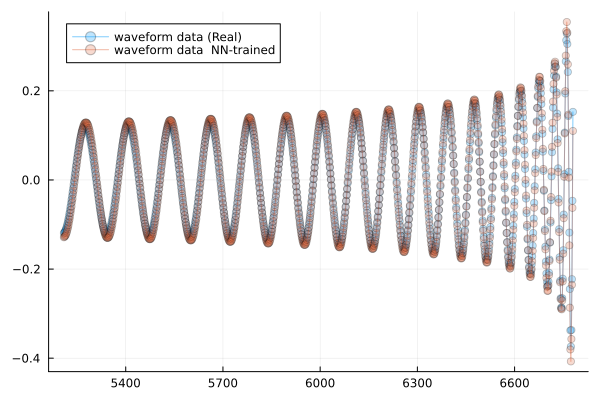

In [14]:
# Optimizez solution and getting the waveform
optimized_solution = solve(remake(prob_nn, p = NN_params_final, tspan=tspan), RK4(), saveat = tsteps, dt = dt, adaptive=false)
pred_waveform_real, pred_waveform_imag = compute_waveform(dt_data, optimized_solution, mass_ratio)

# Plotting the NN and real waveform
plot(tsteps, waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data (Real)")
Plots.plot!(tsteps, pred_waveform_real, markershape=:circle, markeralpha = 0.25, linewidth = 1, alpha = 0.5, label="waveform data  NN-trained")

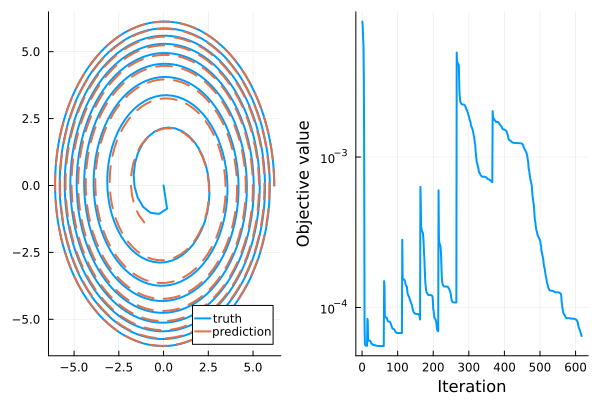

In [15]:
# Plotting the shape of the orbit and the loss function
pred_orbit = soln2orbit(optimized_solution)
orbit_nn1, orbit_nn2 = one2two(pred_orbit, mass1, mass2)
plt1 = plot(x, y, linewidth = 2, label = "truth")
plot!(plt1, orbit_nn1[1,:], orbit_nn1[2,:], linestyle = :dash, linewidth = 2, label = "prediction")
plt2 = plot(losses, yaxis=:log, linewidth = 2, xlabel = "Iteration", ylabel = "Objective value", legend = false)
plt = plot(plt1, plt2, layout = (1,2))
display(plot(plt))

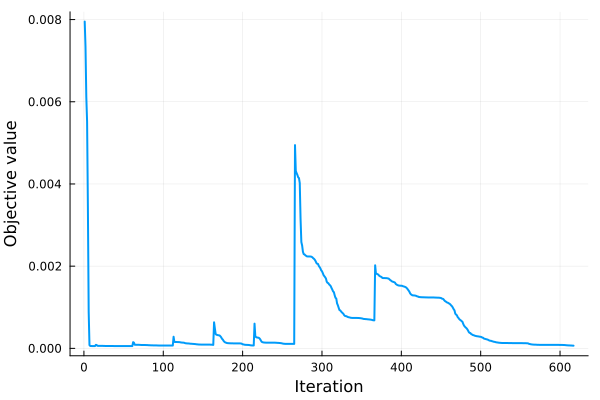

In [16]:
plot(losses, linewidth=2, xlabel="Iteration", ylabel="Objective value", legend=false)

In [18]:
df_solution = DataFrame(time = tsteps[1:length(optimized_solution)],
                        χ = optimized_solution[1,:],
                        ϕ = optimized_solution[2,:],
                        p = optimized_solution[3,:],
                        e = optimized_solution[4,:])

Row,time,χ,ϕ,p,e
,Float32,Float32,Float32,Float32,Float32
1,5209.13,3.14159,0.0,12.37,0.0001
2,5210.7,3.17772,0.036105,12.3671,8.91291e-5
3,5212.27,3.21387,0.0722342,12.3642,7.83244e-5
4,5213.85,3.25002,0.108365,12.3613,6.75926e-5
5,5215.42,3.28618,0.144509,12.3585,5.69306e-5
6,5216.99,3.32237,0.180677,12.3556,4.63348e-5
7,5218.56,3.35856,0.216848,12.3527,3.58121e-5
8,5220.14,3.39478,0.253042,12.3498,2.53557e-5
9,5221.71,3.431,0.289238,12.3469,1.49724e-5


In [19]:
df_trajectories = DataFrame(time = tsteps,
                         true_orbit_x1 = x,
                         true_orbit_y1 = y,
                         true_orbit_x2 = x2,
                         true_orbit_y2 = y2,
                         pred_orbit_x1 = orbit_nn1[1,:],
                         pred_orbit_y1 = orbit_nn1[2,:],
                         pred_orbit_x2 = orbit_nn2[1,:],
                         pred_orbit_y2 = orbit_nn2[2,:])

Row,time,true_orbit_x1,true_orbit_y1,true_orbit_x2,true_orbit_y2,pred_orbit_x1,pred_orbit_y1,pred_orbit_x2,pred_orbit_y2
,Float32,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5209.13,6.18581,0.000799599,-6.18583,-0.000799602,6.18562,0.0,-6.18562,-0.0
2,5210.7,6.1804,0.223431,-6.18041,-0.223432,6.18008,0.223229,-6.18008,-0.223229
3,5212.27,6.16698,0.445821,-6.167,-0.445822,6.16648,0.446207,-6.16648,-0.446207
4,5213.85,6.14558,0.667542,-6.1456,-0.667544,6.14483,0.668505,-6.14483,-0.668505
5,5215.42,6.11621,0.888378,-6.11623,-0.88838,6.11517,0.889901,-6.11517,-0.889901
6,5216.99,6.07891,1.10811,-6.07893,-1.10811,6.0775,1.11017,-6.0775,-1.11017
7,5218.56,6.03363,1.3263,-6.03364,-1.3263,6.0319,1.3289,-6.0319,-1.3289
8,5220.14,5.98048,1.5428,-5.9805,-1.5428,5.9784,1.54592,-5.9784,-1.54592
9,5221.71,5.91958,1.75721,-5.9196,-1.75721,5.91709,1.76083,-5.91709,-1.76083


In [20]:
df_waveforms = DataFrame(time = tsteps,
                        true_waveform_real = waveform_real,
                        true_waveform_imag = 0*waveform_real, # not recorded
                        pred_waveform_real = pred_waveform_real,
                        pred_waveform_imag = pred_waveform_imag,
                        error_real = waveform_real .- pred_waveform_real,
                        error_imag = 0*waveform_real) # not recorded

Row,time,true_waveform_real,true_waveform_imag,pred_waveform_real,pred_waveform_imag,error_real,error_imag
,Float32,Float64,Float64,Float64,Float64,Float64,Float64
1,5209.13,-0.119236,-0.0,-0.128723,-0.000503228,0.00948686,-0.0
2,5210.7,-0.118016,-0.0,-0.127552,0.00977078,0.00953558,-0.0
3,5212.27,-0.116174,-0.0,-0.126381,0.0200448,0.0102072,-0.0
4,5213.85,-0.113743,-0.0,-0.124708,0.0285794,0.0109651,-0.0
5,5215.42,-0.1107,-0.0,-0.122538,0.0370057,0.0118378,-0.0
6,5216.99,-0.107092,-0.0,-0.119185,0.0468013,0.012093,-0.0
7,5218.56,-0.102919,-0.0,-0.115977,0.0543129,0.0130578,-0.0
8,5220.14,-0.0982072,-0.0,-0.111236,0.0635296,0.0130285,-0.0
9,5221.71,-0.0929876,-0.0,-0.106636,0.0709406,0.0136481,-0.0


In [21]:
df_losses = DataFrame(losses = losses)

Row,losses
,Any
1,0.00795204
2,0.00733516
3,0.00611765
4,0.00551547
5,0.00345324
6,0.00088908
7,7.76134e-5
8,5.71626e-5
9,5.67095e-5


In [22]:
df_parameters = DataFrame(parameters = NN_params)

Row,parameters
,Float64
1,-0.265422
2,-0.00823924
3,0.374002
4,0.0731321
5,0.05384
6,0.273817
7,-0.267009
8,0.257566
9,0.0140792


In [23]:
CSV.write("./output/SXS0217_solution.csv", df_solution)
CSV.write("./output/SXS0217_trajectories.csv", df_trajectories)
CSV.write("./output/SXS0217_waveforms.csv", df_waveforms)
CSV.write("./output/SXS0217_losses.csv", df_losses)
CSV.write("./output/SXS0217_parameters.csv", df_parameters)

"./output/SXS0217_parameters.csv"